In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def extract_brushes(path, nameInFile, nameOutContFile):
    
    image = cv2.imread(path + nameInFile)
    
    red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] 
    mask_white = (red >=200) & (green >=200) & (blue >=200)
    mask_black= ~mask_white
    image[:,:,:3][mask_white]=[255,255,255]
    image[:,:,:3][mask_black]=[0,0,0]
    
    plt.imshow(image)
    plt.title("image_orig")
    plt.show()
    
    image = (255-image)    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #to gray scale
    plt.imshow(gray)
    plt.title("gray_orig")
    plt.show()

    scale_percent= 600/gray.shape[1] #percent of established width in order to have all inputs in same scale for a later application a minimum area

    width = int(gray.shape[1] * scale_percent )
    height = int(gray.shape[0] * scale_percent )

    # resize image
    gray = cv2.resize(gray, (width, height))
    image = cv2.resize(image, (width, height))
    image0 = image.copy()
    
    plt.imshow(image)
    plt.title("image_transform")
    plt.show()
    
    plt.imshow(gray)
    plt.title("gray_transform")
    plt.show()  

    # elimino este transformacion (canny), demasiado accurate y da lugar a open contours
    #canny = cv2.Canny(gray, 10, 150)
    #canny = cv2.dilate(canny, None, iterations=1)
    #canny = cv2.erode(canny, None, iterations=1)
    #print("canny")
    #plt.imshow(canny)
    #plt.show()
  
    contours,hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    threshold_area =75  
    
    new_contours=[]    

    for i,cnt in enumerate(contours):        
        area = cv2.contourArea(cnt)         

        if area > threshold_area:             
            new_contours.append(cnt)
            cv2.drawContours(image, contours,i, (0,255,0), 3)  # se marcan los contours en verde
            
    plt.imshow(image)
    plt.title("contours")
    plt.show()  
    
    path_contours=path + '01_contours/'
    cv2.imwrite(path_contours + nameOutContFile, image) # almacenamos en un fichero la salida para seguimiento-validación    
    
    #print(len(new_contours))
    
    # extraer cada pincelada por separado en un fichero
    idx_out=1 #generador de idx para los brush strokes finales, que componen la ddbb
    for idx in range(len(new_contours)):
        image_i=image0.copy() #actuamos sobre una copia   
        
        #red, green, blue = image_i[:,:,0], image_i[:,:,1], image_i[:,:,2] 
        #mask_white = (red >=200) & (green >=200) & (blue >=200)
        #mask_black= ~mask_white
        #image_i[:,:,:3][mask_white]=[255,255,255]
        #image_i[:,:,:3][mask_black]=[0,0,0]
        
        mask_i = np.zeros_like(image_i) # Create mask where white is what we want, black otherwise
        cv2.drawContours(mask_i, new_contours, idx, (255,255,255), -1) # Draw filled contour in mask
        out_i = np.zeros_like(image_i)   # Extract out the object and place into output image
        out_i[mask_i == 255] = image_i[mask_i == 255]
        plt.imshow(out_i)
        plt.show()
        #crop out____________________________________________
        
        (x, y) = np.where((mask_i[:, :, 0]==255) & (mask_i[:, :, 1]==255) & (mask_i[:, :, 2]==255))

        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        
        height=bottomy-topy
        width=bottomx-topx

        brush = out_i[topx: topx + width,topy: topy + height]
        plt.imshow(brush)
        plt.show()       
        
        
        path_brushes=path + '00_bs_db/'
        #cv2.imwrite(path_brushes + "bsu_" + ("0"*4 + str(idx_out))[-5:] + ".jpg", brush)
        
        idx_out+=1    
               
    
    
    return

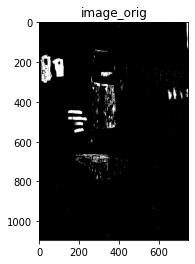

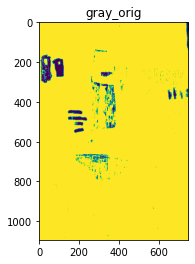

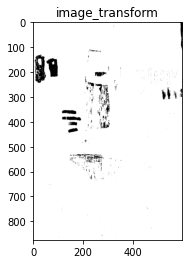

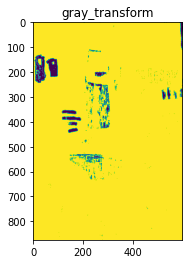

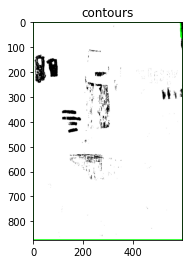

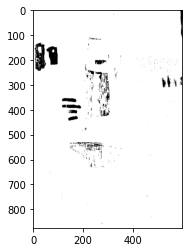

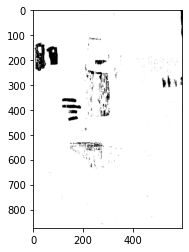

In [6]:
#individual test
#---------------#

path_bs='./data/'

nameInFile="AH01.jpg"
nameOutFile="AH01_contours.jpg"

extract_brushes(path_bs, nameInFile, nameOutFile)

   

In [14]:
path_bs='./data/'

nameInFile="AH01.jpg"
nameOutFile="AH01_contours.jpg"

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [12]:
#!pip install easydev                 #version 0.12.0
#!pip install colormap                #version 1.0.4
#!pip install opencv-python           #version 4.5.5.64
#!pip install colorgram.py            #version 1.2.0
#!pip install extcolors               #version 1.0.0

import cv2
import extcolors

from colormap import rgb2hex

In [15]:
input_name = path_bs + nameInFile
output_width = 900                   #set the output size
img = Image.open(input_name)
wpercent = (output_width/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((output_width,hsize), Image.ANTIALIAS)

#save
resize_name = 'resize_' + input_name  #the resized image name
img.save(resize_name)                 #output location can be specified before resize_name

#read
plt.figure(figsize=(9, 9))
img_url = resize_name
img = plt.imread(img_url)
plt.imshow(img)
plt.axis('off')
plt.show()

/tmp/ipykernel_2854/1650538040.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((output_width,hsize), Image.ANTIALIAS)


FileNotFoundError: [Errno 2] No such file or directory: 'resize_./data/AH01.jpg'

In [26]:
#https://towardsdatascience.com/image-color-extraction-with-python-in-4-steps-8d9370d9216e
    
def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    return df


def exact_color(input_image, resize, tolerance, zoom):
    #background
    bg = 'bg.png'
    fig, ax = plt.subplots(figsize=(192,108),dpi=10)
    fig.set_facecolor('white')
    plt.savefig(bg)
    plt.close(fig)
    
    #resize
    output_width =  img.size[0]#resize
    img = Image.open(input_image)
    if img.size[0] >= resize:
        wpercent = (output_width/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((output_width,hsize), Image.ANTIALIAS)
        resize_name = 'resize_'+ input_image
        img.save(resize_name)
    else:
        resize_name = input_image
    
    #crate dataframe
    img_url = resize_name
    colors_x = extcolors.extract_from_path(img_url, tolerance = tolerance, limit = 13)
    df_color = color_to_df(colors_x)
    
    #annotate text
    list_color = list(df_color['c_code'])
    list_precent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color, list_precent)]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(160,120), dpi = 10)
    
    #donut plot
    wedges, text = ax1.pie(list_precent,
                           labels= text_c,
                           labeldistance= 1.05,
                           colors = list_color,
                           textprops={'fontsize': 150, 'color':'black'})
    plt.setp(wedges, width=0.3)

    #add image in the center of donut plot
    img = mpimg.imread(resize_name)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (0, 0))
    ax1.add_artist(ab)
    
    #color palette
    x_posi, y_posi, y_posi2 = 160, -170, -170
    for c in list_color:
        if list_color.index(c) <= 5:
            y_posi += 180
            rect = patches.Rectangle((x_posi, y_posi), 360, 160, facecolor = c)
            ax2.add_patch(rect)
            ax2.text(x = x_posi+400, y = y_posi+100, s = c, fontdict={'fontsize': 190})
        else:
            y_posi2 += 180
            rect = patches.Rectangle((x_posi + 1000, y_posi2), 360, 160, facecolor = c)
            ax2.add_artist(rect)
            ax2.text(x = x_posi+1400, y = y_posi2+100, s = c, fontdict={'fontsize': 190})

    fig.set_facecolor('white')
    ax2.axis('off')
    bg = plt.imread('bg.png')
    plt.imshow(bg)       
    plt.tight_layout()
    return plt.show()

In [27]:
path_bs='./data/'
nameInFile="AH01.jpg"

input_name = path_bs + nameInFile
exact_color(input_name, 300, 12, 2.5)


UnboundLocalError: local variable 'img' referenced before assignment